# NLG

Para este ejercicio al usar redes neuronales hemos decidido hacer con GoogleColab, para poder usar GPU. Desde este enlace también se puede acceder:

https://colab.research.google.com/drive/1K1TyxwqFURTEOQzsX7V53pVQ5hNMqdkR?usp=sharing

In [29]:
import pandas as pd
import string
import unicodedata
import re

import sys
import pickle
import heapq
import numpy as np
np.random.seed(42)

import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

In [30]:
# Cargamos el dataset de twitter de KimKardashian
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/HillaryClintonTweets.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
df.head()

,Unnamed: 0,date,id,link,retweet,text,author
0,0,Oct 9,785272428905791488,/HillaryClinton/status/785272428905791489,False,Remember. #Debatepic.twitter.com/rlMbTt5WwY,HillaryClinton
1,1,Oct 10,785455909883568128,/HillaryClinton/status/785455909883568128,False,If Trump stands by what he said about women as...,HillaryClinton
2,2,Oct 9,785325012152713216,/HillaryClinton/status/785325012152713216,False,She won. http://hrc.io/2dQkjip #Debatepic.twi...,HillaryClinton
3,3,15m15 minutes ago,787031849197592576,/HillaryClinton/status/787031849197592576,False,"""We are Black, we are proud, and here’s why we...",HillaryClinton
4,4,3h3 hours ago,786992309472722944,/HillaryClinton/status/786992309472722946,False,One adviser called Hillary's efforts to get ki...,HillaryClinton


In [32]:
df.shape

(3356, 7)

Vamos a quitar caracteres extraños pero en este caso no lematizamos ni quitamos stopwords, ya que lo que queremos es que nuestro modelo genere lenguaje natural, no como un robot.

In [33]:
texto = []
# Tabla para eliminar signos de puntuación
table = str.maketrans('', '', string.punctuation)
# Procesamos los textos
processed_texts = []
idx_error = []
for text in df['text']:
    # Eliminamos caracteres extraños
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Eliminamos direcciones web
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    # Eliminamos usuarios de Twitter
    text = re.sub('@[^\s]+','',text)
    # Quitamos el símbolo de los hashtag
    text = text.replace('#', '')
    texto.append(text)

Ahora mismo tenemos una lista se strings (tuits) Unimos todos los tuits en solo string:

In [34]:
text = ' '.join(texto)
text

'Remember. Debatepic.twitter.com/rlMbTt5WwY If Trump stands by what he said about women as locker room talk, he\'s clearly not sorry.pic.twitter.com/Uhw4795mA9 She won.   Debatepic.twitter.com/C4MP8cPONF "We are Black, we are proud, and heres why we are working to elect Hillary."  staffers on why they\'re with her:  pic.twitter.com/vEqIo3APBP One adviser called Hillary\'s efforts to get kids health insurance a "one-woman army inside the White House."  "Everyone knows how bright she is and how resilient she is, but...they\'re going to see how much she cares."  "All the progress we\'ve made these last 8 years is on the ballot." \n\nMake sure you\'re ready to vote:  "You have a chance to reject the politics of fear. You can lift up again the politics of hope.    "Change is possible, but it doesnt just depend on one personit depends on all of us.    StrongerTogether "She knows that in a democracy as big and diverse as this, we can\'t demonize each other.  on Hillary "He may be up at 3am, b

Obtenemos los caracteres únicos de nuestro texto.

In [35]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print('unique chars: {}'.format(len(chars)))

unique chars: 88


Vamos a dividir el texto en cadenas de 20 caracteres con un paso entre cadena y cadena de 2 caracteres.

In [36]:
# Limit the sentences length to chunks of seq_length characters
seq_length = 20

# Spaces between sentences
step = 2

# List to store the sentences
sentences = []

# List to store the next character to be predicted for each sentence
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sentences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])
print('num training examples: {}'.format(len(sentences)))

num training examples: 177527


Para poder introducir esas cadenas en un modelo debemos convertirlas a números, para ello usamos one hot encoder.

In [37]:
# Create one-hot-encoded vectors
X = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vamos a construir nuestro un primer modelo muy simple a ver que tal funciona.

In [38]:
vocab_size = len(chars)

In [39]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(chars))))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               111104    
_________________________________________________________________
dense_4 (Dense)              (None, 88)                11352     
_________________________________________________________________
activation_2 (Activation)    (None, 88)                0         
Total params: 122,456
Trainable params: 122,456
Non-trainable params: 0
_________________________________________________________________
None


Entrenamos el modelo.

In [40]:
# Set the optimizer
optimizer = RMSprop(lr=0.01)

# Compile the network
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the network
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 168650 samples, validate on 8877 samples
Epoch 1/20
168650/168650 [==============================] - 82s 488us/step - loss: 2.0613 - accuracy: 0.4344 - val_loss: 2.0590 - val_accuracy: 0.4531
Epoch 2/20
168650/168650 [==============================] - 82s 488us/step - loss: 1.6317 - accuracy: 0.5440 - val_loss: 1.9609 - val_accuracy: 0.4790
Epoch 3/20
168650/168650 [==============================] - 81s 483us/step - loss: 1.5294 - accuracy: 0.5705 - val_loss: 1.9198 - val_accuracy: 0.4910
Epoch 4/20
168650/168650 [==============================] - 81s 483us/step - loss: 1.4736 - accuracy: 0.5853 - val_loss: 1.9060 - val_accuracy: 0.4967
Epoch 5/20
168650/168650 [==============================] - 81s 481us/step - loss: 1.4362 - accuracy: 0.5943 - val_loss: 1.9253 - val_accuracy: 0.4934
Epoch 6/20
168650/168650 [==============================] - 81s 482us/step - loss: 1.4096 - accuracy: 0.6019 - val_loss: 1.9447 - val_accuracy: 0.4974
Epoch 7/20
168650/168650 [==================

Evaluemos el modelo, primero viendo una gráfica del accuracy o luego una de la función de pérdidas:

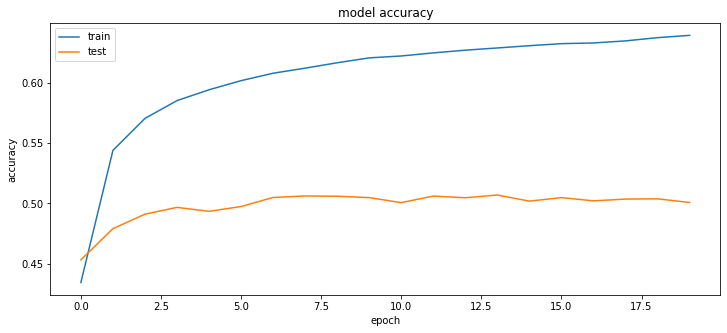

In [41]:
# Model accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

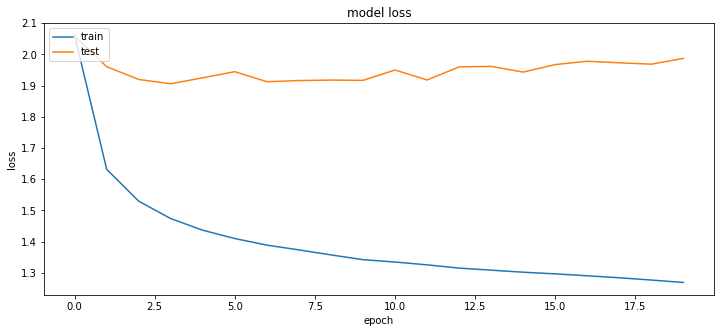

In [42]:
# Model loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

Fijándonos en la gráfica podemos ver como el modelo tiene bastante overfitting yque prácticamente desde la época 10 apenas tiene mejoría. De todas formas aunque un accuracy de 0,5 pueda parecer muy bajo, hay que tener en cuenta que el vocabulario eran 88 caracteres, es decir, sobre 88 posibilidades acierta el 50% de las veces. Visto así puede que no sea tan malo. En cualquier caso vamos aprobarlo prediciendo texto sobre frases reales a ver como se comporta.

In [43]:
def prepare_input(text):
    text = text.lower()
    x = np.zeros((1, seq_length, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
    return x

In [44]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [45]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [46]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [47]:
# Últimos tuist de Hillary Clinton
quotes = [
    "He believed America could be better, even live up to its highest founding ideals of equality & liberty for all. He made good trouble to help us get there.",
    "Here's to another century of pursuing truth, reason, and innovation on the beautiful shores of Wales.",
    "I hope the next Congress honors his life and legacy, and the lives and legacies of his compatriots, by restoring the VRA.",
    "I'm thrilled to discuss this important and complex anniversary with these women.",
    "We can protect abortion rights, access to health care, the environment, and more."
]

In [48]:
# Get top 5 most probable words to these sentences
for q in quotes:
    seq = q[:20].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

he believed america 
['is ', 'should ', 'president ', 'can ', 'to ']

here's to another ce
['ntiny ', 'rtains ', 'lebration ', 'ttertunce ', 'sting ']

i hope the next cong
['rass ', 'edion ', 'oint ', 'ide ', 'Tident ']

i'm thrilled to disc
['rimination ', 'os ', 'uss ', 'lison ', 'ess ']

we can protect abort
['ion ', 'ain ', 'ed ', ' the ', 'y ']



Vemos como en muchos casos son palabras que tienen sentido y que seguramente se hayan repetido mucho en boca de políticos como discrimination, celebration, country y en las dos últimas frases que de hecho acierta con discuss y abortion. 

No es un buen modelo, pero tampoco disponemos de muchos más recursos ya que sólo en entrenar éste que es batante simple y sólo 20 épocas ha tardado bastante.

Vamos a intentarlo con un modelo un poco más complejo a ver como se comporta.

In [49]:
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, len(chars))))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 256)               353280    
_________________________________________________________________
dense_5 (Dense)              (None, 88)                22616     
_________________________________________________________________
activation_3 (Activation)    (None, 88)                0         
Total params: 375,896
Trainable params: 375,896
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
# Set the optimizer
optimizer = tf.keras.optimizers.Adam()

# Compile the network
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the network
history = model.fit(X, y, validation_split=0.05, batch_size=256, epochs=20, shuffle=True).history

Train on 168650 samples, validate on 8877 samples
Epoch 1/20
168650/168650 [==============================] - 46s 274us/step - loss: 2.8608 - accuracy: 0.2422 - val_loss: 2.6033 - val_accuracy: 0.3078
Epoch 2/20
168650/168650 [==============================] - 46s 273us/step - loss: 2.3004 - accuracy: 0.3718 - val_loss: 2.4198 - val_accuracy: 0.3516
Epoch 3/20
168650/168650 [==============================] - 46s 271us/step - loss: 2.1045 - accuracy: 0.4183 - val_loss: 2.3174 - val_accuracy: 0.3770
Epoch 4/20
168650/168650 [==============================] - 45s 266us/step - loss: 1.9696 - accuracy: 0.4534 - val_loss: 2.2304 - val_accuracy: 0.3979
Epoch 5/20
168650/168650 [==============================] - 45s 267us/step - loss: 1.8671 - accuracy: 0.4800 - val_loss: 2.1522 - val_accuracy: 0.4178
Epoch 6/20
168650/168650 [==============================] - 45s 266us/step - loss: 1.7858 - accuracy: 0.5008 - val_loss: 2.1081 - val_accuracy: 0.4333
Epoch 7/20
168650/168650 [==================

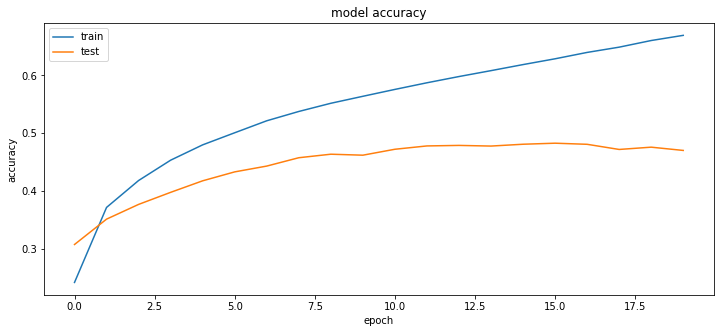

In [51]:
# Model accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

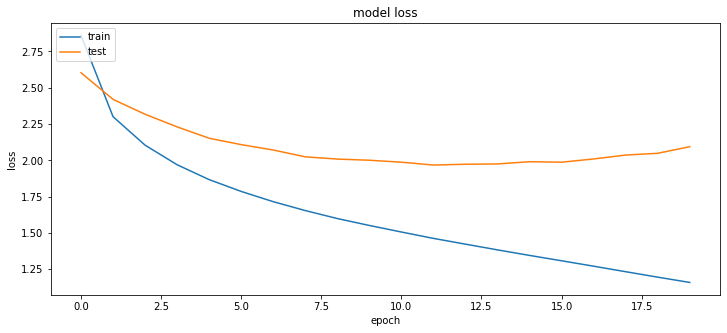

In [52]:
# Model loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

Este modelo parece que tiene un poco menos de overfitting que el anterior pero su precisión tampoco es buena.

In [54]:
# Últimos tuist de Hillary Clinton
quotes = [
    "He believed America could be better, even live up to its highest founding ideals of equality & liberty for all. He made good trouble to help us get there.",
    "Here's to another century of pursuing truth, reason, and innovation on the beautiful shores of Wales.",
    "I hope the next Congress honors his life and legacy, and the lives and legacies of his compatriots, by restoring the VRA.",
    "I'm thrilled to discuss this important and complex anniversary with these women.",
    "We can protect abortion rights, access to health care, the environment, and more."
]

In [55]:
# Get top 5 most probable words to these sentences
for q in quotes:
    seq = q[:20].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

he believed america 
['state ', 'in ', 'choosing ', 'defenting ', 'leadership. ']

here's to another ce
['lebrating ', 'nding ', 'mparyto ', 'ppebange ', 'terned ']

i hope the next cong
['ressing ', 'etting ', 'ationall ', 'less. ', 'hest. ']

i'm thrilled to disc
['rimination ', 'ess ', 'using ', 'ose ', 'asing ']

we can protect abort
['ion ', 'on ', '. ', ' on ', 'ualing ']



Se comporta muy parecido al modelo anterior, incluso algo peor viendo que forma bastantes palabras que no existen.

Podemos seguir probando modelos para ver si conseguimos mejorarlo, lo he intentado con el modelo que tenemos aquí abajo (muy parecido a los que vimos en lase que estaban preentrenados), pero tardaba más de 5 horas en entrenarse y no llegaba a la entrega. Lo dejo como tarea pendiente.

In [ ]:
characters = sorted(list(set(text)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

print('Unique chars: {}'.format(len(characters)))

In [ ]:
X = []
Y = []
length = len(text)
seq_length = 100
for i in range(0, length-seq_length, 1):
    sequence = text[i:i + seq_length]
    label =text[i + seq_length]
    X.append([char_to_n[char] for char in sequence])
    Y.append(char_to_n[label])

In [ ]:
X_modified = np.reshape(X, (len(X), seq_length, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

In [17]:
model_1 = Sequential()
model_1.add(LSTM(256, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_1.add(Dropout(0.2))
model_1.add(LSTM(128))
model_1.add(Dropout(0.2))
model_1.add(Dense(Y_modified.shape[1], activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 88)                11352     
Total params: 209,496
Trainable params: 209,496
Non-trainable params: 0
_________________________________________________________________
